In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/version_finale_subtask2/

/content/drive/MyDrive/version_finale_subtask2


# Import

In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizerFast,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [5]:
!pip install iterative-stratification

In [6]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [7]:
import wandb

wandb.init(mode="disabled")


# 1\) Data analysis

## English


In [8]:
data_eng = pd.read_csv(f'subtask2/train/eng.csv')

print(f"Columns: {data_eng.columns.tolist()}")

expected_cols = ['text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

data_eng = data_eng.dropna(subset=['text'])
data_eng['text'] = data_eng['text'].astype(str)

label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

print(f"\n Label Distribution:")
for col in label_cols:
    if col in data_eng.columns:
        count = data_eng[col].sum()
        pct = (count / len(data_eng)) * 100
        print(f"  {col:20s}: {count:5d} ({pct:5.2f}%)")

data_eng['num_labels'] = data_eng[label_cols].sum(axis=1)
print(f"\n Multi-Label Statistics:")
print(data_eng['num_labels'].value_counts().sort_index())


Columns: ['id', 'text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

 Label Distribution:
  political           :  1150 (35.69%)
  racial/ethnic       :   281 ( 8.72%)
  religious           :   112 ( 3.48%)
  gender/sexual       :    72 ( 2.23%)
  other               :   126 ( 3.91%)

 Multi-Label Statistics:
num_labels
0    2047
1     749
2     299
3     115
4      11
5       1
Name: count, dtype: int64


Generating Class Distribution Plot...


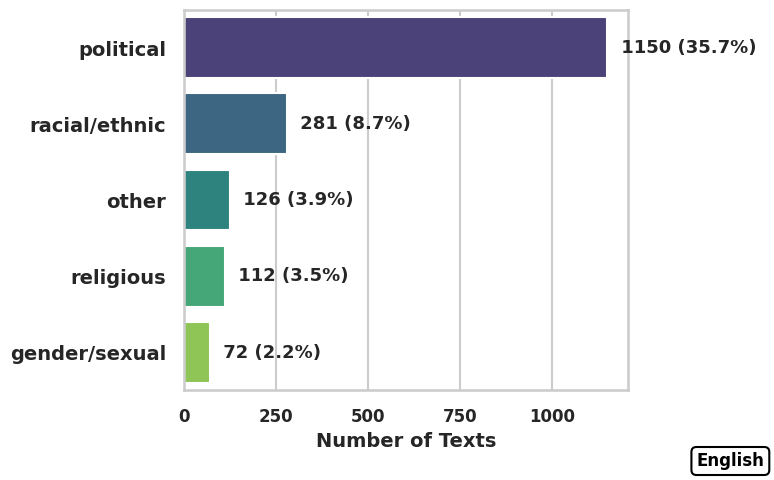

In [12]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

data = {
    'text': ['text'] * 3222,
    'political': [1]*1150 + [0]*(3222-1150),
    'racial/ethnic': [0]*2941 + [1]*281,
    'religious': [0]*3110 + [1]*112,
    'gender/sexual': [0]*3150 + [1]*72,
    'other': [0]*3096 + [1]*126
}
df = pd.DataFrame(data)
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
base_color = "#4c72b0"
palette = sns.color_palette("viridis", len(label_cols))

print("Generating Class Distribution Plot...")

plt.figure(figsize=(8, 5))

counts = df[label_cols].sum().sort_values(ascending=False)
total_samples = len(df)

ax = sns.barplot(x=counts.values, y=counts.index, palette=palette, hue=counts.index, legend=False)


plt.xlabel("Number of Texts", fontsize=14, fontweight='bold')
plt.ylabel("")

plt.yticks(fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')


for i, v in enumerate(counts.values):
    pct = (v / total_samples) * 100

    ax.text(v + 20, i, f" {v} ({pct:.1f}%)", va='center', fontweight='bold', fontsize=13)

plt.tight_layout()

# path_fig1 = f"./Image_saved/class_distribution_english.pdf"
# plt.savefig(path_fig1, format='pdf', bbox_inches='tight', dpi=300)

plt.figtext(
    0.98, 0.02, "English",
    ha='right', va='bottom',
    fontsize=12, fontweight='bold', color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
plt.show()

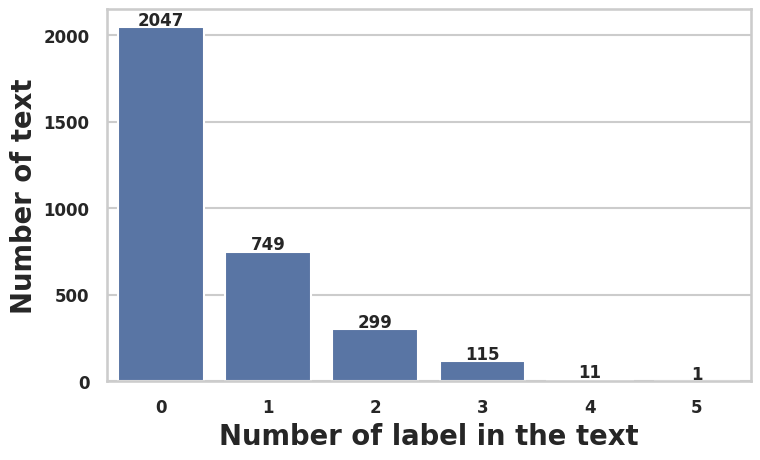

In [ ]:
plt.figure(figsize=(8, 5))

cardinality_counts = data_eng['num_labels'].value_counts().sort_index()
ax = sns.barplot(x=cardinality_counts.index, y=cardinality_counts.values, color=base_color)

plt.xlabel("Number of label in the text",fontweight='bold')
plt.ylabel("Number of text",fontweight='bold')

plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 10, f'{int(height)}', ha="center", fontsize=12, fontweight='bold')

plt.tight_layout()

# path_fig2 = f"./Image_saved/cardinalite_labels.pdf"
# plt.savefig(path_fig2, format='pdf', bbox_inches='tight', dpi=300)
# plt.close()

plt.show()


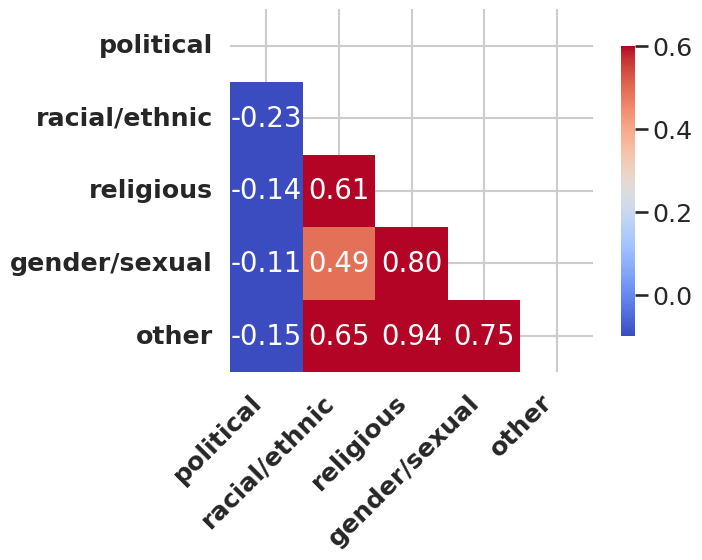

In [ ]:
plt.figure(figsize=(8, 6))

corr_matrix = df[label_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            mask=mask, vmin=-0.1, vmax=0.6, square=True, cbar_kws={'shrink': .8})

plt.xticks(rotation=45, ha='right',fontweight='bold')
plt.yticks(rotation=0,fontweight='bold')
plt.tight_layout()


# path_fig3 = f"./Image_saved/3_correlation_matrix.pdf"
# plt.savefig(path_fig3, format='pdf', bbox_inches='tight', dpi=300)
# # plt.close()

plt.show()

## Swahili


In [ ]:
data_swa = pd.read_csv(f'subtask2/train/swa.csv')

print(f"Columns: {data_swa.columns.tolist()}")

expected_cols = ['text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

data_swa = data_swa.dropna(subset=['text'])
data_swa['text'] = data_swa['text'].astype(str)

label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

print(f"\n Label Distribution:")
for col in label_cols:
    if col in data_swa.columns:
        count = data_swa[col].sum()
        pct = (count / len(data_swa)) * 100
        print(f"  {col:20s}: {count:5d} ({pct:5.2f}%)")

data_swa['num_labels'] = data_swa[label_cols].sum(axis=1)
print(f"\n Multi-Label Statistics:")
print(data_swa['num_labels'].value_counts().sort_index())


Columns: ['id', 'text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

 Label Distribution:
  political           :   186 ( 2.66%)
  racial/ethnic       :  2483 (35.52%)
  religious           :   247 ( 3.53%)
  gender/sexual       :   156 ( 2.23%)
  other               :   555 ( 7.94%)

 Multi-Label Statistics:
num_labels
0    3487
1    3387
2     113
3       2
4       2
Name: count, dtype: int64


Generating Class Distribution Plot...


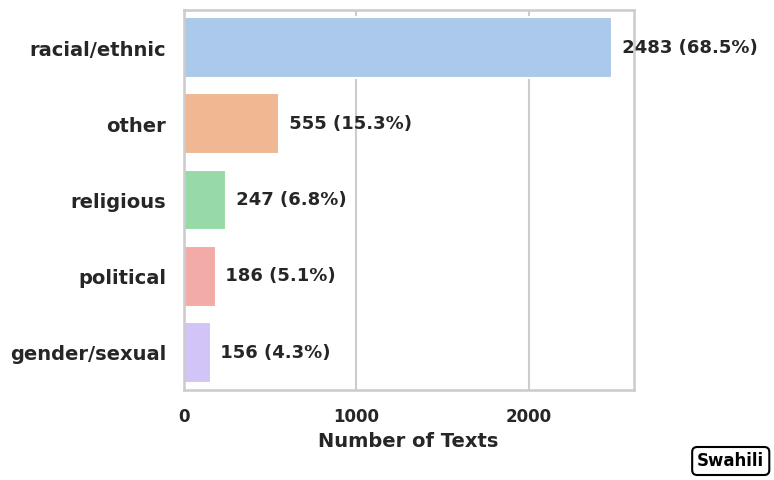

In [11]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

data = {
    'text': ['text'] * 3627,
    'political': [1]*186 + [0]*(3627-186),
    'racial/ethnic': [0]*(3627-2483) + [1]*2483,
    'religious': [0]*(3627-247) + [1]*247,
    'gender/sexual': [0]*(3627-156) + [1]*156,
    'other': [0]*(3627-555) + [1]*555
}
df = pd.DataFrame(data)
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
base_color = "#4c72b0"
palette = sns.color_palette("pastel", len(label_cols))


print("Generating Class Distribution Plot...")

plt.figure(figsize=(8, 5))

counts = df[label_cols].sum().sort_values(ascending=False)
total_samples = len(df)

ax = sns.barplot(x=counts.values, y=counts.index, palette=palette, hue=counts.index, legend=False)


plt.xlabel("Number of Texts", fontsize=14, fontweight='bold')
plt.ylabel("")

plt.yticks(fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')


for i, v in enumerate(counts.values):
    pct = (v / total_samples) * 100

    ax.text(v + 20, i, f" {v} ({pct:.1f}%)", va='center', fontweight='bold', fontsize=13)

plt.tight_layout()

# path_fig1 = f"./Image_saved/class_distribution_swahili.pdf"
# plt.savefig(path_fig1, format='pdf', bbox_inches='tight', dpi=300)


plt.figtext(
    0.98, 0.02, "Swahili",
    ha='right', va='bottom',
    fontsize=12, fontweight='bold', color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
plt.show()

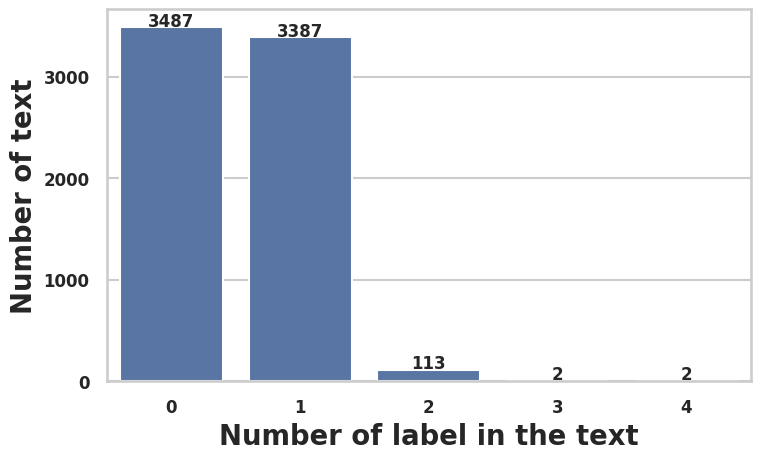

In [ ]:
plt.figure(figsize=(8, 5))

cardinality_counts = data_swa['num_labels'].value_counts().sort_index()
ax = sns.barplot(x=cardinality_counts.index, y=cardinality_counts.values, color=base_color)

plt.xlabel("Number of label in the text",fontweight='bold')
plt.ylabel("Number of text",fontweight='bold')

plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 10, f'{int(height)}', ha="center", fontsize=12, fontweight='bold')

plt.tight_layout()

# path_fig2 = f"./Image_saved/cardinalite_labels.pdf"
# plt.savefig(path_fig2, format='pdf', bbox_inches='tight', dpi=300)
# plt.close()

plt.show()


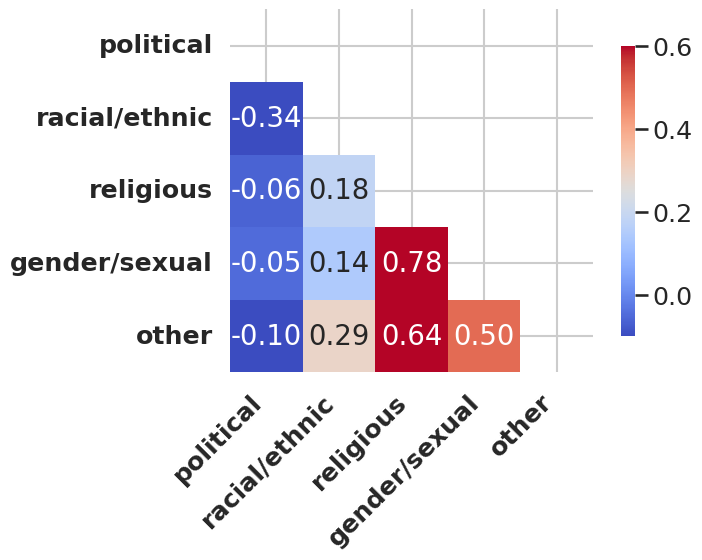

In [ ]:
plt.figure(figsize=(8, 6))

corr_matrix = df[label_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            mask=mask, vmin=-0.1, vmax=0.6, square=True, cbar_kws={'shrink': .8})

plt.xticks(rotation=45, ha='right',fontweight='bold')
plt.yticks(rotation=0,fontweight='bold')
plt.tight_layout()

# path_fig3 = f"./Image_saved/3_correlation_matrix.pdf"
# plt.savefig(path_fig3, format='pdf', bbox_inches='tight', dpi=300)

# Lancer la génération
plt.show()

# 2\) Model

In [ ]:
# @title train/test split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_stratified_split(df, test_size=0.2, random_state=42):
    """
    Stratified split train/test
    return two dataframes (train and test)
    """
    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

    X = df.index.values
    y = df[label_cols].values

    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    train_index, test_index = next(msss.split(X, y))

    train_df = df.loc[df.index[train_index]].copy()
    val_df = df.loc[df.index[test_index]].copy()

    print(f" Split done: Train ({len(train_df)}) / Test ({len(val_df)})")
    print("\nClass distribution for data test:")
    for col in label_cols:
        nb_train = train_df[col].sum()
        nb_test = val_df[col].sum()
        ratio = nb_test / (nb_train + nb_test)
        print(f" {col:15s} : Train={nb_train}, Test={nb_test} (Ratio Test={ratio:.1%})")

    return train_df, val_df



In [ ]:
def calculate_pos_weights(df, label_cols):
    """
    Calculata pos_weights
    """
    weights = []
    total_rows = len(df)


    for col in label_cols:
        pos_count = df[col].sum()
        neg_count = total_rows - pos_count

        weight = neg_count / (pos_count + 1e-5)

        weight = min(weight, 15.0)

        weights.append(weight)
        print(f"  {col:15s}: {pos_count:5d} positive -> weight = {weight:.2f}")

    return torch.tensor(weights)

In [ ]:
# @title tokenize, model, dataset
def tokenize(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True)
    return tokenizer

def model_pre_trained(model_name):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5,
        problem_type="multi_label_classification"
    )
    return model

class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze(0) for key in encoding.keys()}

        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [ ]:
# @title compute metrics and train function

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

class MultiLabelTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")


        weights = self.class_weights.to(model.device)

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    predictions, labels = p
    probs = 1 / (1 + np.exp(-predictions))

    thresholds = np.array([0.5, 0.4, 0.3, 0.2, 0.3])

    y_pred = (probs > thresholds).astype(int)

    y_true = labels

    return {
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'accuracy': accuracy_score(y_true, y_pred)
    }

def train_model(train, val, output_arg, tokenizer, model):

    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
    dynamic_weights = calculate_pos_weights(train, label_cols)

    train_labels = train[label_cols].values.tolist()
    val_labels = val[label_cols].values.tolist()


    train_dataset = PolarizationDataset(train['text'].tolist(), train_labels, tokenizer)
    val_dataset = PolarizationDataset(val['text'].tolist(), val_labels, tokenizer)

    training_args = TrainingArguments(
        output_dir=output_arg,
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_strategy="epoch",
        fp16=torch.cuda.is_available()
    )

    trainer = MultiLabelTrainer(
        model=model,
        class_weights=dynamic_weights,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    trainer.train()


    eval_results = trainer.evaluate()
    print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

    return trainer

In [ ]:
# @title save function
def save_model(path_for_saving, trainer,tokenizer):
  print("\n Saving model...")
  trainer.save_model(path_for_saving)
  tokenizer.save_pretrained(path_for_saving)


In [ ]:

# @title prediction function
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm

class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# --- 2. Fonction Predict Multi-Label ---
def predict_multilabel(model_path, data_dev, thresholds=None):
    """
    model_path: where the model is saved
    data_dev: data for predicttion
    thresholds:  Array of 5 thresholds
    """

    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification")

    predict_dataset = InferenceDataset(data_dev['text'].tolist(), tokenizer)
    predict_loader = DataLoader(predict_dataset, batch_size=32, shuffle=False)

    model.to(device)
    model.eval()

    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

    if thresholds is None:
        thresholds = np.array([0.5] * 5)
    else:
        thresholds = np.array(thresholds)
        print(f"Threshold : {dict(zip(label_cols, thresholds))}")

    all_preds = []

    with torch.no_grad():
        for batch in tqdm(predict_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            probs = torch.sigmoid(outputs.logits)

            probs_np = probs.cpu().numpy()

            batch_preds = (probs_np > thresholds).astype(int)

            all_preds.extend(batch_preds)

    final_matrix = np.array(all_preds)

    for idx, col_name in enumerate(label_cols):
        data_dev[col_name] = final_matrix[:, idx]

    return data_dev


## BERTweeter model

In [ ]:
# @title Load data
data = pd.read_csv('subtask2/train/eng.csv')
train, val = get_stratified_split(data, test_size=0.15)


In [ ]:
# @title define tokenizer and model
model_name = "vinai/bertweet-base"
output_arg = "./model_subtask2/BertTweeter_model/argument_model"

tokenizer = tokenize(model_name)
model = model_pre_trained(model_name)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
# @title train
trainer = train_model(train, val, output_arg, tokenizer, model)

Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,1.069700,0.954770,0.222922,0.972676,0.000310
2,0.891800,0.776102,0.291571,0.920957,0.000310
3,0.775300,0.688336,0.330817,0.921975,0.143389
4,0.716000,0.641612,0.357152,0.900385,0.463066
5,0.671600,0.631296,0.356412,0.908227,0.484482


Macro F1 score on validation set: 0.35715160708224253


In [ ]:
# @title save model
path_save = "./model_subtask2/BertTweeter_model/model_trained"
save_model(path_save,trainer, tokenizer)


 Saving model...


In [ ]:
# columns : ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
thresholds = [0.5, 0.4, 0.3, 0.2, 0.3]

data_dev_eng = pd.read_csv("subtask2/dev/eng.csv")

df_resultat = predict_multilabel(
    model_path="./model_subtask2/BertTweeter_model/model_trained",
    data_dev=data_dev_eng,
    thresholds=thresholds
)



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Threshold : {'political': np.float64(0.5), 'racial/ethnic': np.float64(0.4), 'religious': np.float64(0.3), 'gender/sexual': np.float64(0.2), 'other': np.float64(0.3)}


100%|██████████| 5/5 [00:01<00:00,  4.29it/s]


In [ ]:
df_resultat

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_f66ca14d60851371f9720aaf4ccd9b58,God is with Ukraine and Zelensky,0,0,0,0,0
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,"4 Dems, 2 Republicans Luzerne County Council s...",0,0,0,0,0
2,eng_95770ff547ea5e48b0be00f385986483,Abuse Survivor Recounts Her Struggles at YWCA ...,0,0,0,0,0
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,"After Rwanda, another deportation camp disaster",0,0,0,0,0
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,Another plea in Trump election interference probe,0,0,0,0,0
...,...,...,...,...,...,...,...
155,eng_9f170d76134d91a9aae08ec49a0eb1b1,wait what the fuck they DID process my voter r...,1,0,0,1,0
156,eng_3caf621f17c15e73ad88d1d58ace76e1,Ballot stuffing by Dems when Republicans were ...,0,0,0,0,0
157,eng_d735bda395a80ff9861c0ab78c5fb9a3,"ProRussian propaganda. Lies, Lies, Lies!",1,1,1,1,1
158,eng_576cca5b3a10908cc024bc4c4c6e61b3,how are things going for the Azov battalion si...,1,1,1,1,1


In [ ]:
label_cols = ['id','political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
pred_eng = df_resultat[label_cols]
pred_eng.to_csv("./model_subtask2/BertTweeter_model/result_model/pred_eng_only.csv", index=False)


In [ ]:
import pandas as pd

In [ ]:
pd.read_csv('subtask2/train/eng.csv')

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0
...,...,...,...,...,...,...,...
3217,eng_d7af338f325fcc12d4c107c591c64a19,the internalized xenophobia seething fr ppl sh...,0,0,0,0,0
3218,eng_8371147528d6f09acbe9b647c8fa5eb7,the radical left hates chick peas,1,0,0,0,0
3219,eng_4d188ccdfb84eeeaed31b7f28af538ca,this is how xenophobia and misogyny looks like,1,0,0,1,0
3220,eng_867cc5be4f80dafae67ab5f0f70a1ee8,yeah and committing war crimes,0,0,0,0,0


In [ ]:
pd.read_csv("./model_subtask2/BertTweeter_model/result_model/pred_eng_only.csv")

,id,political,racial/ethnic,religious,gender/sexual,other
0,eng_f66ca14d60851371f9720aaf4ccd9b58,0,0,0,0,0
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,0,0,0,0,0
2,eng_95770ff547ea5e48b0be00f385986483,0,0,0,0,0
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,0,0,0,0,0
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,0,0,0,0,0
...,...,...,...,...,...,...
155,eng_9f170d76134d91a9aae08ec49a0eb1b1,1,0,0,1,0
156,eng_3caf621f17c15e73ad88d1d58ace76e1,0,0,0,0,0
157,eng_d735bda395a80ff9861c0ab78c5fb9a3,1,1,1,1,1
158,eng_576cca5b3a10908cc024bc4c4c6e61b3,1,1,1,1,1


## Deberta model

In [ ]:
# @title Load data
data = pd.read_csv('subtask2/train/eng.csv')
train, val = get_stratified_split(data, test_size=0.15)



In [ ]:
# @title define tokenizer and model
model_name = "microsoft/deberta-v3-base"
output_arg = "./model_subtask2/deberta_model/argument_model"

tokenizer = tokenize(model_name)
model = model_pre_trained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title train
trainer = train_model(train, val, output_arg, tokenizer, model)

Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,1.071300,0.937600,0.251876,0.923719,0.203290
2,0.876500,0.706107,0.327832,0.862294,0.530726
3,0.716200,0.596986,0.379243,0.881250,0.590006
4,0.636900,0.542093,0.416587,0.881989,0.630043
5,0.570900,0.521797,0.410076,0.917376,0.627250


Macro F1 score on validation set: 0.41658681357656124


In [ ]:
# @title save model
path_save = "./model_subtask2/deberta_model/model_trained"
save_model(path_save,trainer, tokenizer)


 Saving model...


In [ ]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.3]

data_dev_eng = pd.read_csv("subtask2/dev/eng.csv")

df_resultat = predict_multilabel(
    model_path="./model_subtask2/deberta_model/model_trained",
    data_dev=data_dev_eng,
    thresholds=thresholds
)
label_cols = ['id','political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
pred_eng = df_resultat[label_cols]
pred_eng.to_csv("./model_subtask2/deberta_model/result_model/pred_eng_only.csv", index=False)


The tokenizer you are loading from './model_subtask2/deberta_model/model_trained' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Threshold : {'political': np.float64(0.5), 'racial/ethnic': np.float64(0.4), 'religious': np.float64(0.3), 'gender/sexual': np.float64(0.2), 'other': np.float64(0.3)}


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


## mDebert English and swahili


In [ ]:
# @title load data and split
data_eng = pd.read_csv('subtask2/train/eng.csv')
data_swa = pd.read_csv('subtask2/train/swa.csv')
data = pd.concat([data_eng,data_swa])

train, val = get_stratified_split(data, test_size=0.2)


 Split done: Train (13372) / Test (3285)

Class distribution for data test:
  - political       : Train=2116, Test=511 (Ratio Test=19.5%)
  - racial/ethnic   : Train=3707, Test=920 (Ratio Test=19.9%)
  - religious       : Train=527, Test=138 (Ratio Test=20.8%)
  - gender/sexual   : Train=313, Test=70 (Ratio Test=18.3%)
  - other           : Train=881, Test=205 (Ratio Test=18.9%)


In [ ]:
# @title define tokenizer and model
model_name = "microsoft/mdeberta-v3-base"
output_arg = "./model_subtask2/mdeberta_model/argument_model"

tokenizer = tokenize(model_name)
model = model_pre_trained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title train
trainer = train_model(train, val, output_arg, tokenizer, model)


⚖️  Calcul automatique des poids (Class Balancing) :
  - political      :  2116 positifs -> Poids = 5.32
  - racial/ethnic  :  3707 positifs -> Poids = 2.61
  - religious      :   527 positifs -> Poids = 15.00
  - gender/sexual  :   313 positifs -> Poids = 15.00
  - other          :   881 positifs -> Poids = 14.18


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,0.885800,0.653218,0.404362,0.897301,0.234399
2,0.625200,0.561811,0.504571,0.823747,0.558295
3,0.503500,0.496517,0.483949,0.878330,0.528463
4,0.429200,0.464042,0.518385,0.881325,0.591781
5,0.385400,0.457775,0.525959,0.883721,0.614612


Macro F1 score on validation set: 0.5259593783428076


In [ ]:
# @title save model
path_save = "./model_subtask2/mdeberta_model/model_trained"
save_model(path_save,trainer, tokenizer)


 Saving model...


In [ ]:
val_eng = val[val['id'].astype(str).str.contains('eng', na=False)]

In [ ]:

def find_optimal_thresholds(trainer, val_dataset):
    predictions_output = trainer.predict(val_dataset)
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids


    probs = 1 / (1 + np.exp(-logits))

    best_thresholds = []
    class_names = ['Political', 'Racial', 'Religious', 'Gender', 'Other']

    for i in range(5):
        best_f1 = 0
        best_thresh = 0.5

        for t in np.arange(0.1, 1.0, 0.05):
            preds_col = (probs[:, i] > t).astype(int)
            score = f1_score(true_labels[:, i], preds_col)

            if score > best_f1:
                best_f1 = score
                best_thresh = t

        best_thresholds.append(best_thresh)
        print(f"  - {class_names[i]}: best thresholds = {best_thresh:.2f} (F1={best_f1:.3f})")

    return best_thresholds
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
val_labels = val[label_cols].values.tolist()
val_dataset = PolarizationDataset(val['text'].tolist(), val_labels, tokenizer)
optimal_thresholds = find_optimal_thresholds(trainer, val_dataset)


  - Political: best thresholds = 0.75 (F1=0.810)
  - Racial: best thresholds = 0.65 (F1=0.817)
  - Religious: best thresholds = 0.90 (F1=0.833)
  - Gender: best thresholds = 0.75 (F1=0.462)
  - Other: best thresholds = 0.80 (F1=0.441)


In [ ]:
# @title prediction for english
thresholds = [0.75, 0.65, 0.90, 0.75, 0.80]

data_dev_eng = pd.read_csv("subtask2/dev/eng.csv")

df_resultat = predict_multilabel(
    model_path="./model_subtask2/mdeberta_model/model_trained",
    data_dev=data_dev_eng,
    thresholds=thresholds
)
label_cols = ['id','political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
pred_eng = df_resultat[label_cols]
pred_eng.to_csv("./model_subtask2/mdeberta_model/result_model/pred_eng_only.csv", index=False)



The tokenizer you are loading from './model_subtask2/mdeberta_model/model_trained' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Threshold : {'political': np.float64(0.75), 'racial/ethnic': np.float64(0.65), 'religious': np.float64(0.9), 'gender/sexual': np.float64(0.75), 'other': np.float64(0.8)}


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


In [ ]:
# @title prediction for swahili
thresholds = [0.75, 0.65, 0.90, 0.75, 0.80]

data_dev_swa = pd.read_csv("subtask2/dev/swa.csv")

df_resultat = predict_multilabel(
    model_path="./model_subtask2/mdeberta_model/model_trained",
    data_dev=data_dev_swa,
    thresholds=thresholds
)
label_cols = ['id','political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
pred_swa = df_resultat[label_cols]
pred_swa.to_csv("./model_subtask2/mdeberta_model/result_model/pred_swa.csv", index=False)



The tokenizer you are loading from './model_subtask2/mdeberta_model/model_trained' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Threshold : {'political': np.float64(0.75), 'racial/ethnic': np.float64(0.65), 'religious': np.float64(0.9), 'gender/sexual': np.float64(0.75), 'other': np.float64(0.8)}


100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


## m-deberta + data augmentation


In [ ]:
# @title load data and split
import pandas as pd
from sklearn.model_selection import train_test_split

def create_balanced_multilingual_dataset():
    df_core = pd.read_csv('subtask2/train/eng.csv')


    train_core, val_final = get_stratified_split(df_core, test_size=0.1)

    print(f"Dataset (EN): {len(train_core)} exemples")

    datasets = {
        'swa': pd.read_csv('subtask2/train/swa.csv'),
        'deu': pd.read_csv('subtask2/train/deu.csv'),
        'pol': pd.read_csv('subtask2/train/pol.csv'),
        'rus': pd.read_csv('subtask2/train/rus.csv'),
        'spa': pd.read_csv('subtask2/train/spa.csv'),
        'arb': pd.read_csv('subtask2/train/arb.csv'),
        'ita': pd.read_csv('subtask2/train/ita.csv'),
        'tur': pd.read_csv('subtask2/train/tur.csv'),
        'fas': pd.read_csv('subtask2/train/fas.csv'),
        'zho': pd.read_csv('subtask2/train/zho.csv'),
    }

    df_aux = pd.concat(datasets.values(), ignore_index=True)

    # Data augmentation per category
    TARGET_COUNT = 1500

    augmented_data = [train_core]

    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']


    for col in label_cols:
        current_count = train_core[col].sum()

        if current_count < TARGET_COUNT:
            needed = TARGET_COUNT - current_count
            print(f" {col}: we have {current_count}, we need {needed}.take in the others data")

            available_aux = df_aux[df_aux[col] == 1]

            if len(available_aux) > 0:
                take_n = min(len(available_aux), needed)

                sampled = available_aux.sample(n=take_n, random_state=42)

                augmented_data.append(sampled)


            else:
                print(f"Not enough data .")
        else:
            print(f" {col}: {current_count} examples.")

    df_train_final = pd.concat(augmented_data).drop_duplicates(subset=['id'])

    df_train_final = df_train_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n Training Dataset : {len(df_train_final)} examples.")
    print("Final Distribution  :")
    print(df_train_final[label_cols].sum())

    return df_train_final, val_final


In [ ]:

# Utilisation
train, val = create_balanced_multilingual_dataset()


In [ ]:
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
print(f"\n Label Distribution:")
for col in label_cols:
    if col in train.columns:
        count = train[col].sum()
        pct = (count / len(train)) * 100
        print(f"  {col:20s}: {count:5d} ({pct:5.2f}%)")

train['num_labels'] = train[label_cols].sum(axis=1)
print(f"\n Multi-Label Statistics:")
print(train['num_labels'].value_counts().sort_index())



 Label Distribution:
  political           :  2982 (35.45%)
  racial/ethnic       :  2207 (26.24%)
  religious           :  1691 (20.10%)
  gender/sexual       :  1687 (20.05%)
  other               :  1759 (20.91%)

 Multi-Label Statistics:
num_labels
0    1848
1    3765
2    1969
3     714
4      99
5      17
Name: count, dtype: int64


In [ ]:
# @title define tokenizer and model
model_name = "microsoft/mdeberta-v3-base"
output_arg = "./model_subtask2/mdeberta_eng_model/argument_model"

tokenizer = tokenize(model_name)
model = model_pre_trained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title train
trainer = train_model(train, val, output_arg, tokenizer, model)

  - political      :  2982 positive -> weight = 1.82
  - racial/ethnic  :  2207 positive -> weight = 2.81
  - religious      :  1691 positive -> weight = 3.97
  - gender/sexual  :  1687 positive -> weight = 3.99
  - other          :  1759 positive -> weight = 3.78


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,0.909400,0.466356,0.285547,0.300625,0.616099
2,0.686100,0.405319,0.424215,0.473551,0.631579
3,0.578200,0.384453,0.407539,0.572542,0.572755
4,0.516900,0.376523,0.420361,0.592686,0.591331
5,0.484900,0.378152,0.429565,0.539162,0.628483


Macro F1 score on validation set: 0.4295652185332708


In [ ]:
# @title save model
path_save = "./model_subtask2/mdeberta_eng_model/model_trained"
save_model(path_save,trainer, tokenizer)


 Saving model...


In [ ]:

def find_optimal_thresholds(trainer, val_dataset):
    predictions_output = trainer.predict(val_dataset)
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids


    probs = 1 / (1 + np.exp(-logits))

    best_thresholds = []
    class_names = ['Political', 'Racial', 'Religious', 'Gender', 'Other']

    for i in range(5):
        best_f1 = 0
        best_thresh = 0.5

        for t in np.arange(0.1, 1.0, 0.05):
            preds_col = (probs[:, i] > t).astype(int)
            score = f1_score(true_labels[:, i], preds_col)

            if score > best_f1:
                best_f1 = score
                best_thresh = t

        best_thresholds.append(best_thresh)
        print(f"  - {class_names[i]}: best thresholds = {best_thresh:.2f} (F1={best_f1:.3f})")

    return best_thresholds
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
val_labels = val[label_cols].values.tolist()
val_dataset = PolarizationDataset(val['text'].tolist(), val_labels, tokenizer)
optimal_thresholds = find_optimal_thresholds(trainer, val_dataset)


  - Political: best thresholds = 0.45 (F1=0.680)
  - Racial: best thresholds = 0.65 (F1=0.526)
  - Religious: best thresholds = 0.50 (F1=0.667)
  - Gender: best thresholds = 0.65 (F1=0.615)
  - Other: best thresholds = 0.15 (F1=0.188)


In [ ]:
# @title prediction for english
thresholds = [0.45, 0.65, 0.50, 0.65, 0.15]

data_dev_eng = pd.read_csv("subtask2/dev/eng.csv")

df_resultat = predict_multilabel(
    model_path="./model_subtask2/mdeberta_eng_model/model_trained",
    data_dev=data_dev_eng,
    thresholds=thresholds
)
label_cols = ['id','political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
pred_eng = df_resultat[label_cols]
pred_eng.to_csv("./model_subtask2/mdeberta_eng_model/result_model/pred_eng_only.csv", index=False)



The tokenizer you are loading from './model_subtask2/mdeberta_eng_model/model_trained' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Threshold : {'political': np.float64(0.45), 'racial/ethnic': np.float64(0.65), 'religious': np.float64(0.5), 'gender/sexual': np.float64(0.65), 'other': np.float64(0.15)}


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


## k-fold


In [ ]:
train, val = create_balanced_multilingual_dataset()


In [ ]:

import torch
import gc
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification

def train_k_fold(df_combined, model_name, output_base_dir, num_folds=5):

    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
    X = df_combined['text'].values
    y = df_combined[label_cols].values

    mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_index, val_index) in enumerate(mskf.split(X, y)):
        print(f" FOLD {fold + 1}/{num_folds}")

        train_df = df_combined.iloc[train_index].reset_index(drop=True)
        val_df = df_combined.iloc[val_index].reset_index(drop=True)

        fold_weights = calculate_pos_weights(train_df, label_cols)

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=5,
            problem_type="multi_label_classification"
        )

        train_dataset = PolarizationDataset(train_df['text'].tolist(), train_df[label_cols].values.tolist(), tokenizer)
        val_dataset = PolarizationDataset(val_df['text'].tolist(), val_df[label_cols].values.tolist(), tokenizer)

        fold_output_arg_dir = f"{output_base_dir}/argument_model/fold-{fold+1}"

        training_args = TrainingArguments(
            output_dir=fold_output_arg_dir,
            num_train_epochs=4,
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            gradient_accumulation_steps=4,
            per_device_eval_batch_size=16,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_total_limit=1,
            metric_for_best_model="eval_f1_macro",
            greater_is_better=True,
            fp16=torch.cuda.is_available(),
            disable_tqdm=False
        )

        trainer = MultiLabelTrainer(
            model=model,
            class_weights=fold_weights,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        trainer.train()

        eval_metrics = trainer.evaluate()
        print(f" Result Fold {fold+1} : F1 Macro = {eval_metrics['eval_f1_macro']:.4f}")
        fold_results.append(eval_metrics['eval_f1_macro'])

        fold_output_model_dir = f"{output_base_dir}/model_trained/fold-{fold+1}"

        trainer.save_model(fold_output_model_dir)
        tokenizer.save_pretrained(fold_output_model_dir)

        del model
        del trainer
        del tokenizer
        torch.cuda.empty_cache()
        gc.collect()

    print(f"\n Average F1 Macro on {num_folds} folds : {np.mean(fold_results):.4f}")
    return fold_results



In [ ]:
# --- UTILISATION ---
df_final = train
train_k_fold(df_final, "microsoft/mdeberta-v3-base", "./model_subtask2/mdeberta_kfold_model/", num_folds=5)

 FOLD 1/5
  - political      :  2386 positive -> weight = 1.82
  - racial/ethnic  :  1766 positive -> weight = 2.81
  - religious      :  1353 positive -> weight = 3.97
  - gender/sexual  :  1350 positive -> weight = 3.98
  - other          :  1407 positive -> weight = 3.78


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,No log,0.755595,0.528502,0.929789,0.196078
2,No log,0.610394,0.601735,0.882844,0.226976
3,0.741100,0.570321,0.657222,0.888100,0.374926
4,0.741100,0.558057,0.669678,0.885306,0.395128


✅ Résultat Fold 1 : F1 Macro = 0.6697
 FOLD 2/5
  - political      :  2386 positive -> weight = 1.82
  - racial/ethnic  :  1765 positive -> weight = 2.81
  - religious      :  1352 positive -> weight = 3.98
  - gender/sexual  :  1350 positive -> weight = 3.99
  - other          :  1407 positive -> weight = 3.78


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,No log,0.719050,0.544662,0.914880,0.218787
2,No log,0.606445,0.629820,0.904498,0.291914
3,0.737200,0.580853,0.655219,0.892980,0.345422
4,0.737200,0.566147,0.673724,0.882582,0.375743


✅ Résultat Fold 2 : F1 Macro = 0.6737
 FOLD 3/5
  - political      :  2385 positive -> weight = 1.82
  - racial/ethnic  :  1766 positive -> weight = 2.81
  - religious      :  1353 positive -> weight = 3.97
  - gender/sexual  :  1349 positive -> weight = 3.99
  - other          :  1408 positive -> weight = 3.78


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,No log,0.718178,0.557205,0.874868,0.218193
2,No log,0.609347,0.607474,0.903012,0.265755
3,0.734000,0.573223,0.654818,0.881431,0.348989
4,0.734000,0.565188,0.685345,0.876840,0.407848


✅ Résultat Fold 3 : F1 Macro = 0.6853
 FOLD 4/5
  - political      :  2385 positive -> weight = 1.82
  - racial/ethnic  :  1765 positive -> weight = 2.81
  - religious      :  1353 positive -> weight = 3.97
  - gender/sexual  :  1350 positive -> weight = 3.99
  - other          :  1407 positive -> weight = 3.78


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,No log,0.762162,0.536992,0.861492,0.233056
2,No log,0.617919,0.590265,0.893425,0.253864
3,0.768200,0.571737,0.639010,0.900191,0.299049
4,0.768200,0.558788,0.665587,0.888332,0.361474


✅ Résultat Fold 4 : F1 Macro = 0.6656
 FOLD 5/5
  - political      :  2386 positive -> weight = 1.82
  - racial/ethnic  :  1766 positive -> weight = 2.81
  - religious      :  1353 positive -> weight = 3.97
  - gender/sexual  :  1349 positive -> weight = 3.99
  - other          :  1407 positive -> weight = 3.78


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Accuracy
1,No log,0.752758,0.511483,0.958639,0.157457
2,No log,0.602907,0.597900,0.919052,0.273916
3,0.748400,0.556774,0.657849,0.899516,0.348188
4,0.748400,0.547751,0.668368,0.892411,0.367201


✅ Résultat Fold 5 : F1 Macro = 0.6684

🏆 Average F1 Macro on 5 folds : 0.6725


[0.6696784717134491,
 0.6737238028472293,
 0.6853445460852775,
 0.6655868176265256,
 0.6683681858632023]

In [ ]:
def predict_ensemble(base_model_dir, data_dev, num_folds=5, thresholds=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    accumulated_probs = np.zeros((len(data_dev), 5))

    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

    for fold in range(num_folds):
        fold_path = f"{base_model_dir}/fold-{fold+1}"
        print(f" Model Fold {fold+1} : {fold_path}")

        tokenizer = AutoTokenizer.from_pretrained(fold_path)
        model = AutoModelForSequenceClassification.from_pretrained(fold_path)
        model.to(device)
        model.eval()

        dataset = InferenceDataset(data_dev['text'].tolist(), tokenizer)
        loader = DataLoader(dataset, batch_size=32, shuffle=False)

        fold_probs = []

        with torch.no_grad():
            for batch in tqdm(loader, desc=f"Pred Fold {fold+1}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)

                probs = torch.sigmoid(outputs.logits).cpu().numpy()
                fold_probs.extend(probs)

        accumulated_probs += np.array(fold_probs)

        del model
        torch.cuda.empty_cache()

    avg_probs = accumulated_probs / num_folds

    if thresholds is None:
        thresholds = np.array([0.5] * 5)
    else:
        thresholds = np.array(thresholds)

    final_preds = (avg_probs > thresholds).astype(int)

    for idx, col in enumerate(label_cols):
        data_dev[col] = final_preds[:, idx]
        data_dev[f'{col}_prob'] = avg_probs[:, idx]

    return data_dev

df_test = pd.read_csv("subtask2/dev/eng.csv")

df_result = predict_ensemble(
     base_model_dir="./model_subtask2/mdeberta_kfold_model/model_trained/",
     data_dev=df_test,
     num_folds=5,
     #thresholds=my_thresholds
 )

 Model Fold 1 : ./model_subtask2/mdeberta_kfold_model/model_trained//fold-1


The tokenizer you are loading from './model_subtask2/mdeberta_kfold_model/model_trained//fold-1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Pred Fold 1: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


 Model Fold 2 : ./model_subtask2/mdeberta_kfold_model/model_trained//fold-2


The tokenizer you are loading from './model_subtask2/mdeberta_kfold_model/model_trained//fold-2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Pred Fold 2: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


 Model Fold 3 : ./model_subtask2/mdeberta_kfold_model/model_trained//fold-3


The tokenizer you are loading from './model_subtask2/mdeberta_kfold_model/model_trained//fold-3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Pred Fold 3: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


 Model Fold 4 : ./model_subtask2/mdeberta_kfold_model/model_trained//fold-4


The tokenizer you are loading from './model_subtask2/mdeberta_kfold_model/model_trained//fold-4' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Pred Fold 4: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


 Model Fold 5 : ./model_subtask2/mdeberta_kfold_model/model_trained//fold-5


The tokenizer you are loading from './model_subtask2/mdeberta_kfold_model/model_trained//fold-5' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Pred Fold 5: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


In [ ]:
df_result

,id,text,political,racial/ethnic,religious,gender/sexual,other,political_prob,racial/ethnic_prob,religious_prob,gender/sexual_prob,other_prob
0,eng_f66ca14d60851371f9720aaf4ccd9b58,God is with Ukraine and Zelensky,0,0,0,0,0,0.255564,0.065421,0.027198,0.029623,0.040535
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,"4 Dems, 2 Republicans Luzerne County Council s...",0,0,0,0,0,0.086156,0.046206,0.021696,0.038309,0.036834
2,eng_95770ff547ea5e48b0be00f385986483,Abuse Survivor Recounts Her Struggles at YWCA ...,0,0,0,0,0,0.098983,0.044482,0.017647,0.037549,0.040443
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,"After Rwanda, another deportation camp disaster",0,0,0,0,0,0.093400,0.041588,0.018480,0.029288,0.035686
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,Another plea in Trump election interference probe,0,0,0,0,0,0.105578,0.033396,0.018349,0.032607,0.032568
...,...,...,...,...,...,...,...,...,...,...,...,...
155,eng_9f170d76134d91a9aae08ec49a0eb1b1,wait what the fuck they DID process my voter r...,0,0,0,0,0,0.267946,0.035861,0.017301,0.031778,0.059872
156,eng_3caf621f17c15e73ad88d1d58ace76e1,Ballot stuffing by Dems when Republicans were ...,1,0,0,0,0,0.761876,0.104245,0.044768,0.036309,0.075189
157,eng_d735bda395a80ff9861c0ab78c5fb9a3,"ProRussian propaganda. Lies, Lies, Lies!",1,0,0,0,0,0.925873,0.464886,0.291909,0.111748,0.380777
158,eng_576cca5b3a10908cc024bc4c4c6e61b3,how are things going for the Azov battalion si...,1,1,0,0,0,0.861019,0.744400,0.427605,0.046542,0.160501


In [ ]:
label_cols = ['id','political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
pred_eng = df_result[label_cols]
pred_eng.to_csv("./model_subtask2/mdeberta_kfold_model/result_model/pred_eng_only.csv", index=False)
